In [15]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
def collect_data_and_plot(df, n_stores, n_warehouses, n_samples, test_mode, setting_name, underage_cost):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'] + '/model.pt',
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/{n_stores}-{n_warehouses}/{row['Architecture Class']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    w_holding_by_warehouse_all = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        batch_size = n_samples
        num_batches = n_samples // batch_size
        if test_mode == 'test_on_dev':
            num_steps = 50
            start_step = 16
        else:
            num_steps = 200
            start_step = 100
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        avg_s_underage.append(relevant_data['s_underage_costs'].sum() / underage_cost)
        avg_s_holding.append(relevant_data['s_holding_costs'].sum() / underage_cost)
        
        # Split warehouse holding costs by warehouse
        w_holding_costs = []
        for i in range(n_warehouses):
            w_holding_costs.append(relevant_data[f'w_{i}_holding_costs'].sum() / underage_cost)
        w_holding_by_warehouse_all.append(w_holding_costs)
        avg_w_holding.append(sum(w_holding_costs))  # Total warehouse holding cost
        avg_cost.append(-relevant_data['s_underage_costs'].sum() - relevant_data['s_holding_costs'].sum() - avg_w_holding[-1])

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = [-x for x in avg_s_underage] # Negating to make profit positive
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding
    
    # Add individual warehouse holding costs
    for i in range(n_warehouses):
        df_copy[f'w_{i}_holding'] = [x[i] for x in w_holding_by_warehouse_all]
        
    df_copy['avg_profit'] = avg_cost # This is now profit since we negated the costs above
    df = df_copy

    # Calculate relative profit as percentage of maximum overall profit
    max_profit = df['avg_profit'].max()
    df['profit'] = df['avg_profit'] / max_profit * 100

    plot_data = df.pivot(columns='Architecture Class', 
                        values=['profit', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'] + 
                        [f'w_{i}_holding' for i in range(n_warehouses)])
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Profit (% of maximum)', 'Store Profit(1e7)', 'Store Holding Cost(1e7)', 
             'Total Warehouse Holding Cost(1e7)', 'Individual Warehouse Holding Costs(1e7)']
    y_values = ['profit', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    # Create a single legend at the top
    legend_lines = []
    legend_labels = []
    for arch in df['Architecture Class'].unique():
        if arch == 'Just_In_Time':
            continue
        legend_lines.append(plt.Line2D([0], [0], color=color_scheme[arch], 
                                     linestyle=linestyle_scheme[arch], marker='o'))
        legend_labels.append(arch)
    
    fig.legend(legend_lines, legend_labels, loc='upper center', 
              bbox_to_anchor=(0.5, 0.98), ncol=len(legend_labels))

    for i, (ax, title, y_value) in enumerate(zip(axes[:-1], titles[:-1], y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                plot_values = plot_data[y_value][arch].to_numpy()
                if y_value != 'profit':
                    plot_values = plot_values / 1e7  # Scale down non-profit values by 1e7
                x_values = np.ones_like(plot_values)  # Create x values with same dimension as plot_values
                ax.plot(x_values, plot_values, marker='o',
                       color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_ylabel(title)
        ax.set_title(title)
        ax.grid(True)
        ax.set_xticks([]) # Remove x-axis ticks

    # Plot individual warehouse holding costs
    for arch in df['Architecture Class'].unique():
        if arch == 'Just_In_Time':
            continue
        # Plot all points without labels since legend is at the top
        for i in range(n_warehouses):
            if arch in plot_data[f'w_{i}_holding'].columns:
                plot_values = plot_data[f'w_{i}_holding'][arch].to_numpy() / 1e7
                x_values = np.ones_like(plot_values) * (i + 1)
                axes[-1].plot(x_values, plot_values, marker='o',
                            color=color_scheme[arch], linestyle=linestyle_scheme[arch])

    axes[-1].set_ylabel('Warehouse Holding Cost(1e7)')
    axes[-1].set_title('Individual Warehouse Holding Costs(1e7)')
    axes[-1].grid(True)
    axes[-1].set_xticks(range(1, n_warehouses + 1))
    axes[-1].set_xticklabels([f'W{i}' for i in range(n_warehouses)])

    plt.tight_layout()
    # Adjust layout to make room for the legend at the top
    plt.subplots_adjust(top=0.92)
    plt.show()
    return df


Error processing files in /user/ml4723/Prj/NIC/ray_results/n_warehouse_46_3_real/data_driven_net_n_warehouses_real/run_2025-03-24_20-18-17/run_a63cb_00011_11_config=n_warehouse_46_3_real_lost_demand,early_stop_check_epochs=10,learning_rate=0.0001,master_n_warehouses=51_2025-03-24_20-18-17: All rows contained NaN values in loss columns
Error processing files in /user/ml4723/Prj/NIC/ray_results/n_warehouse_46_3_real/data_driven_net_n_warehouses_real/run_2025-03-24_20-18-17/run_a63cb_00001_1_config=n_warehouse_46_3_real_lost_demand,early_stop_check_epochs=10,learning_rate=0.0010,master_n_warehouses=512_2025-03-24_20-18-17: All rows contained NaN values in loss columns
Error processing files in /user/ml4723/Prj/NIC/ray_results/n_warehouse_46_3_real/data_driven_net_n_warehouses_real/run_2025-03-24_20-18-17/run_a63cb_00005_5_config=n_warehouse_46_3_real_lost_demand,early_stop_check_epochs=10,learning_rate=0.0001,master_n_warehouses=256_2025-03-24_20-18-17: All rows contained NaN values in lo

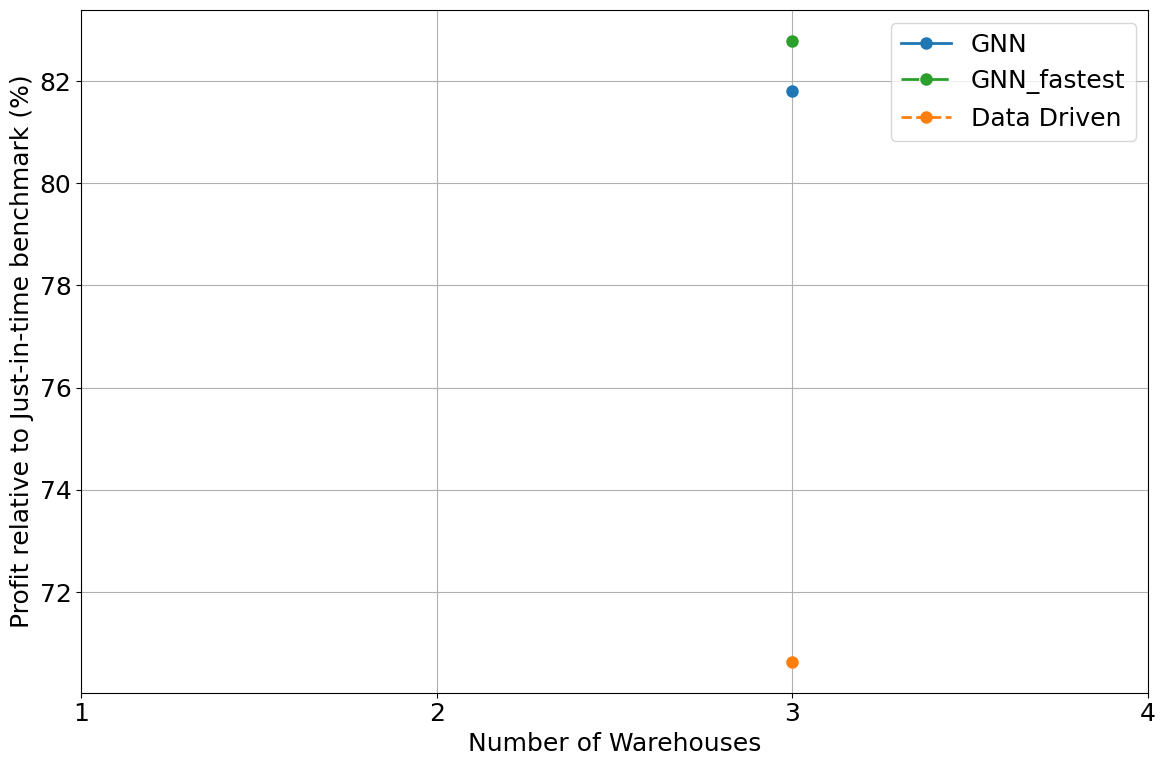

In [57]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_46_3_real"]#["n_warehouse_46_1_real", "n_warehouse_46_2_real", "n_warehouse_46_3_real", "n_warehouse_46_4_real"]

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and line styles
color_scheme = {
    "GNN": "#1f77b4",    # Blue
    "GNN_fastest": "#2ca02c",  # Green
    "Data Driven": "#ff7f0e"   # Orange
}

linestyle_scheme = {
    "GNN": "-",               # Solid
    "GNN_fastest": "-.",      # Dash-dot
    "Data Driven": "--"       # Dashed
}

# Define paths for each architecture
architectures = {
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_real',
    "GNN_fastest": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_real_fastest',
    "Data Driven": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/data_driven_net_n_warehouses_real',
    "Just-in-time": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/just_in_time_real'
}

architectures_hyperparam_names = {
    "GNN": "GNN_real",
    "GNN_fastest": "GNN_real_fastest",
    "Data Driven": "data_driven_net_n_warehouses_real",
    "Just-in-time": "just_in_time_real"
}

sort_by = 'train_loss'
pick_row_from_run_by = 'train_loss'

dfs = []

# Create dataframes for each architecture and testset
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        n_warehouses = int(testset_name.split('_')[3])  # Extract warehouse number from testset name
        
        df = results_interpretor.make_table({1: path},
            {'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
            test_loss_limit = 100)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', architectures_hyperparam_names[arch_name])
        df['n_warehouses'] = n_warehouses
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate relative profit percentage using just-in-time as baseline
stats_by_arch_and_warehouses = {}
for n_warehouses in range(1, 5):  # 1 to 4 warehouses
    warehouse_data = df[df['n_warehouses'] == n_warehouses].copy()
    if warehouse_data.empty:
        continue
        
    jit_loss = warehouse_data[warehouse_data['Architecture Class'] == 'Just-in-time']['Dev Loss'].values[0]
    warehouse_data.loc[:, 'Profit %'] = (warehouse_data['Dev Loss'] / jit_loss) * 100
    
    for arch in ['GNN', 'GNN_fastest', 'Data Driven']:  # Plot these three
        key = arch
        if key not in stats_by_arch_and_warehouses:
            stats_by_arch_and_warehouses[key] = []
            
        arch_data = warehouse_data[warehouse_data['Architecture Class'] == arch]
        if not arch_data.empty:
            profits = arch_data['Profit %'].to_numpy()
            mean_profit = np.mean(profits)
            std_profit = np.std(profits)
            ci_95 = 1.96 * std_profit / np.sqrt(len(profits))
            stats_by_arch_and_warehouses[key].append({
                'n_warehouses': n_warehouses,
                'mean_profit': mean_profit,
                'ci_lower': mean_profit - ci_95,
                'ci_upper': mean_profit + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_warehouses.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        warehouses_array = stats_df['n_warehouses'].to_numpy()
        mean_profit_array = stats_df['mean_profit'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(warehouses_array, mean_profit_array,
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch],
                linewidth=2,
                marker='o',
                markersize=8,
                label=arch)
        
        plt.fill_between(warehouses_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('Number of Warehouses', fontsize=FONTSIZE)
plt.ylabel('Profit relative to Just-in-time benchmark (%)', fontsize=FONTSIZE)
plt.grid(True)
plt.legend(fontsize=FONTSIZE)

plt.xticks(range(1, 5), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [38]:
print(df.to_string())

   # of stores                    hyperparam_name  samples Architecture Class  Learning Rate  Train Loss    Dev Loss  # of runs                                                                                                                                                                                                                                                                     path  n_warehouses
0            1                           GNN_real        1                GNN          0.001 -701.874751 -605.765410          8                           /user/ml4723/Prj/NIC/ray_results/n_warehouse_46_3_real/GNN_real/run_2025-03-25_08-27-08/run_7839e_00007_7_config=n_warehouse_46_3_real_lost_demand,early_stop_check_epochs=10,learning_rate=0.0010,n_MP=3,repeats=3,sample_2025-03-25_08-27-09             3
1            1                   GNN_real_fastest        1        GNN_fastest          0.001 -696.710245 -612.944696          9                   /user/ml4723/Prj/NIC/ray_results/n_wareh

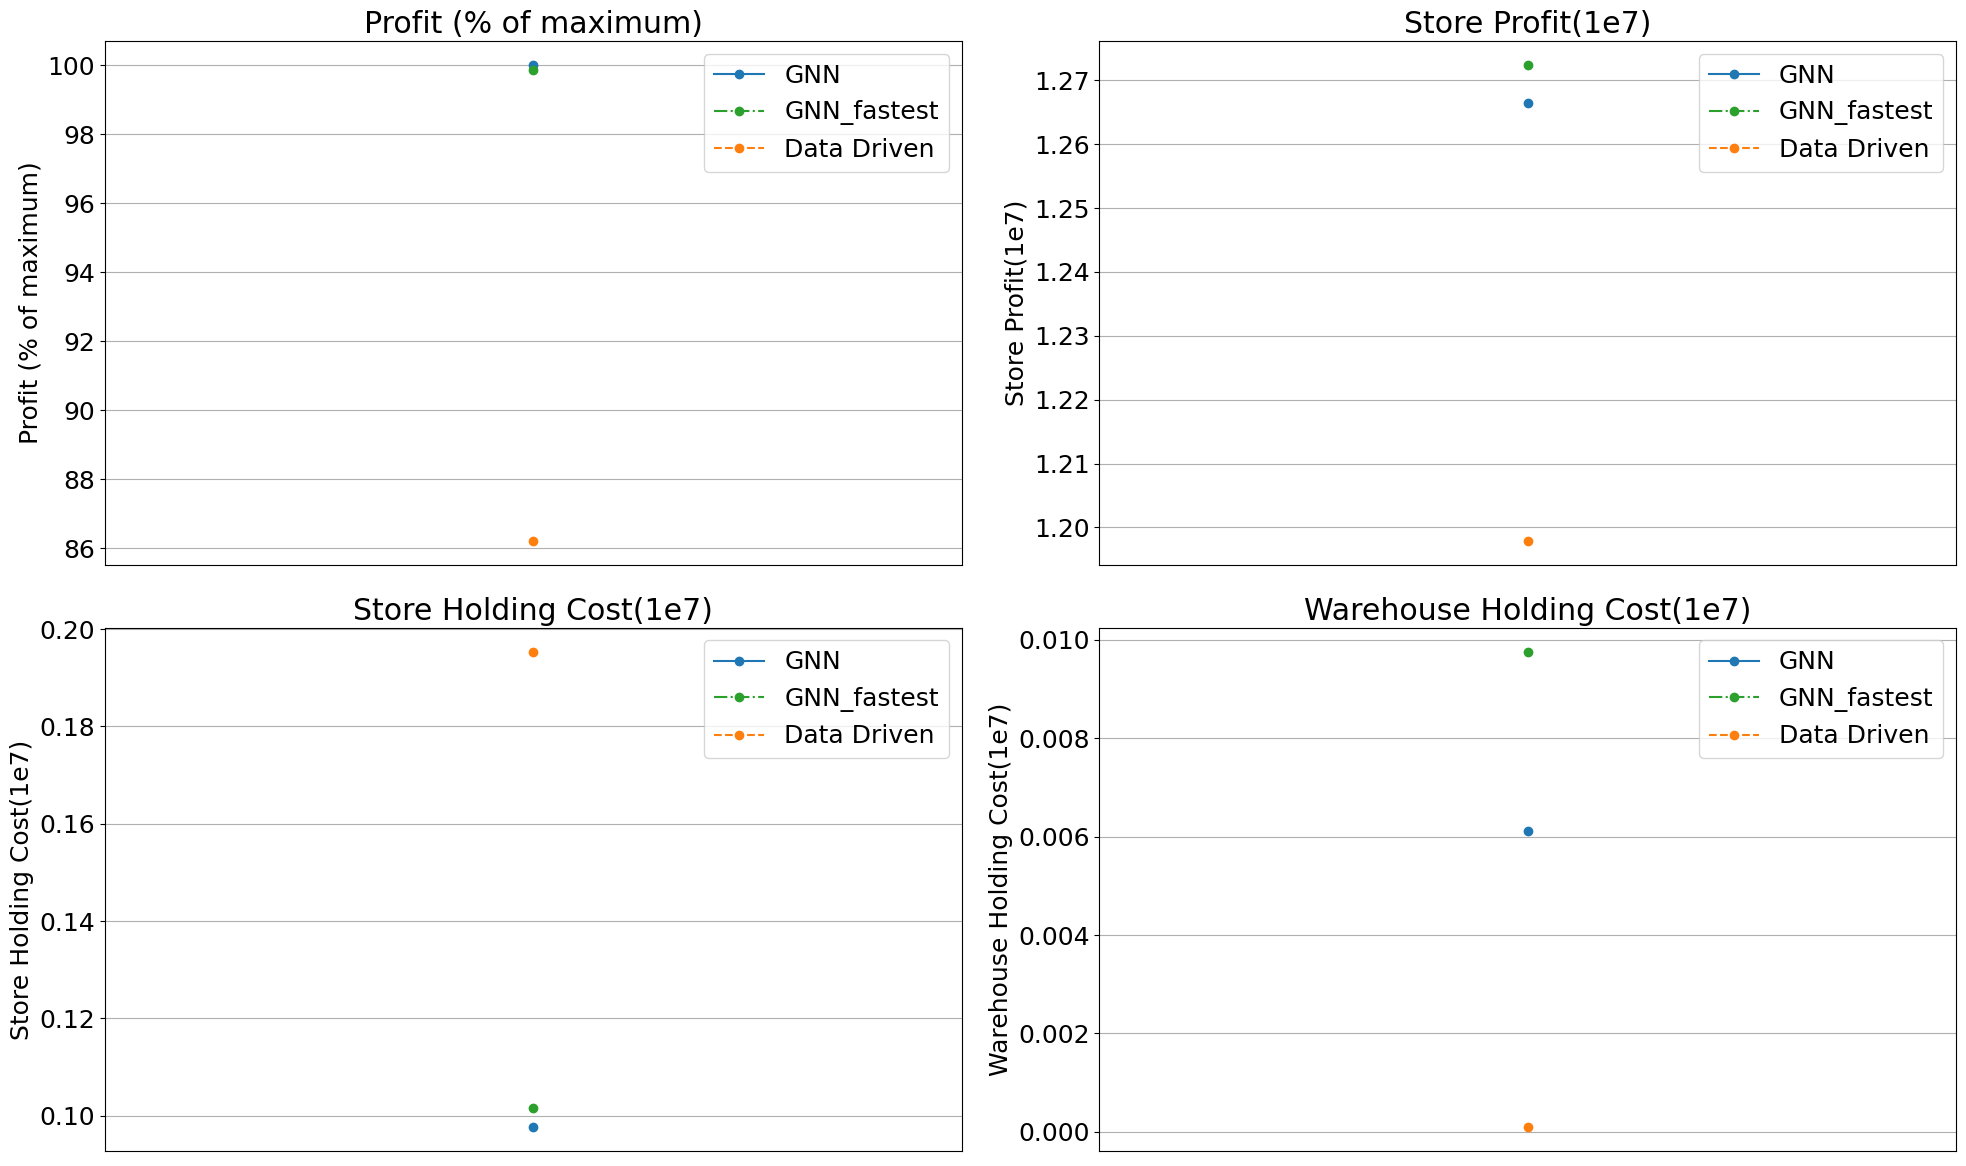

,# of stores,hyperparam_name,samples,Architecture Class,Learning Rate,Train Loss,Dev Loss,# of runs,path,n_warehouses,avg_s_underage,avg_s_holding,avg_w_holding,avg_profit,profit
0,1,GNN_real,1,GNN,0.001,-701.874751,-605.765410,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,1.266372e+07,9.759710e+05,61105.633160,1.046398e+08,100.000000
1,1,GNN_real_fastest,1,GNN_fastest,0.001,-696.710245,-612.944696,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,1.272373e+07,1.015883e+06,97584.192524,1.044924e+08,99.859080
2,1,data_driven_net_n_warehouses_real,1,Data Driven,0.001,-758.271196,-523.043384,29,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,1.197899e+07,1.953813e+06,928.426410,9.021820e+07,86.217843


In [58]:
df_analysis = df[df['Architecture Class'] != 'Just-in-time']
collect_data_and_plot(df_analysis, 46, 109, "test_on_dev", "n_warehouse_46_3_real_lost_demand", 9)

In [220]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_20_3_real"]#, "n_warehouse_46_2_real", "n_warehouse_46_3_real", "n_warehouse_46_4_real"]

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and line styles
color_scheme = {
    "GNN": "#1f77b4",    # Blue
    "GNN_fastest": "#2ca02c",  # Green
    "GNN_cheapest": "#d62728",  # Red
    # "Data Driven": "#ff7f0e",   # Orange
    # "GNN_bottleneck": "#9467bd",  # Purple
    "GNN_skipconnection": "#8c564b"  # Brown
}

linestyle_scheme = {
    "GNN": "-",               # Solid
    "GNN_fastest": "-.",      # Dash-dot
    "GNN_cheapest": ":",      # Dotted
    # "Data Driven": "--",      # Dashed
    # "GNN_bottleneck": "--",   # Dashed
    "GNN_skipconnection": "-."  # Dash-dot
}

# Define paths for each architecture
architectures = {
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_real',
    "GNN_fastest": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_real_fastest',
    "GNN_cheapest": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_real_cheapest',
    # "GNN_bottleneck": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_real_bottleneck',
    # "GNN_skipconnection": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_real_skipconnection',
    # "Data Driven": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/data_driven_net_n_warehouses_real',
    "Just-in-time": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/just_in_time_real'
}

architectures_hyperparam_names = {
    "GNN": "GNN_real",
    "GNN_fastest": "GNN_real_fastest",
    "GNN_cheapest": "GNN_real_cheapest",
    "GNN_skipconnection": "GNN_real_skipconnection",
    "Data Driven": "data_driven_net_n_warehouses_real",
    "Just-in-time": "just_in_time_real"
}

sort_by = 'train_loss'
pick_row_from_run_by = 'train_loss'

dfs = []

# Create dataframes for each architecture and testset
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        n_warehouses = int(testset_name.split('_')[3])  # Extract warehouse number from testset name
        
        df = results_interpretor.make_table({1: path},
            {'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
            test_loss_limit = 100)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', architectures_hyperparam_names[arch_name])
        df['n_warehouses'] = n_warehouses
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate relative profit percentage using just-in-time as baseline
stats_by_arch_and_warehouses = {}
for n_warehouses in range(1, 5):  # 1 to 4 warehouses
    warehouse_data = df[df['n_warehouses'] == n_warehouses].copy()
    if warehouse_data.empty:
        continue
        
    jit_loss = warehouse_data[warehouse_data['Architecture Class'] == 'Just-in-time']['Dev Loss'].values[0]
    warehouse_data.loc[:, 'Profit %'] = (warehouse_data['Dev Loss'] / jit_loss) * 100
    
    for arch in ['GNN', 'GNN_fastest', 'GNN_cheapest', 'GNN_bottleneck', 'GNN_skipconnection', 'Data Driven']:  # Plot these six
        key = arch
        if key not in stats_by_arch_and_warehouses:
            stats_by_arch_and_warehouses[key] = []
            
        arch_data = warehouse_data[warehouse_data['Architecture Class'] == arch]
        if not arch_data.empty:
            profits = arch_data['Profit %'].to_numpy()
            mean_profit = np.mean(profits)
            std_profit = np.std(profits)
            ci_95 = 1.96 * std_profit / np.sqrt(len(profits))
            stats_by_arch_and_warehouses[key].append({
                'n_warehouses': n_warehouses,
                'mean_profit': mean_profit,
                'ci_lower': mean_profit - ci_95,
                'ci_upper': mean_profit + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_warehouses.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        warehouses_array = stats_df['n_warehouses'].to_numpy()
        mean_profit_array = stats_df['mean_profit'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(warehouses_array, mean_profit_array,
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch],
                linewidth=2,
                marker='o',
                markersize=8,
                label=arch)
        
        plt.fill_between(warehouses_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('Number of Warehouses', fontsize=FONTSIZE)
plt.ylabel('Profit relative to Just-in-time benchmark (%)', fontsize=FONTSIZE)
plt.grid(True)
plt.legend(fontsize=FONTSIZE)

plt.xticks(range(1, 5), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/user/ml4723/Prj/NIC/ray_results/n_warehouse_20_3_real/just_in_time_real'

In [214]:
df

,# of stores,hyperparam_name,samples,Architecture Class,Learning Rate,Train Loss,Dev Loss,# of runs,path,n_warehouses
0,1,GNN_real,1,GNN,0.0010,-333.402857,-290.857991,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,3
1,1,GNN_real_fastest,1,GNN_fastest,0.0001,-322.880886,-285.429238,7,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,3
2,1,GNN_real_cheapest,1,GNN_cheapest,0.0010,-327.619688,-289.167343,7,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,3
3,1,just_in_time_real,1,Just-in-time,NaN,-421.696444,-381.152321,3,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,3


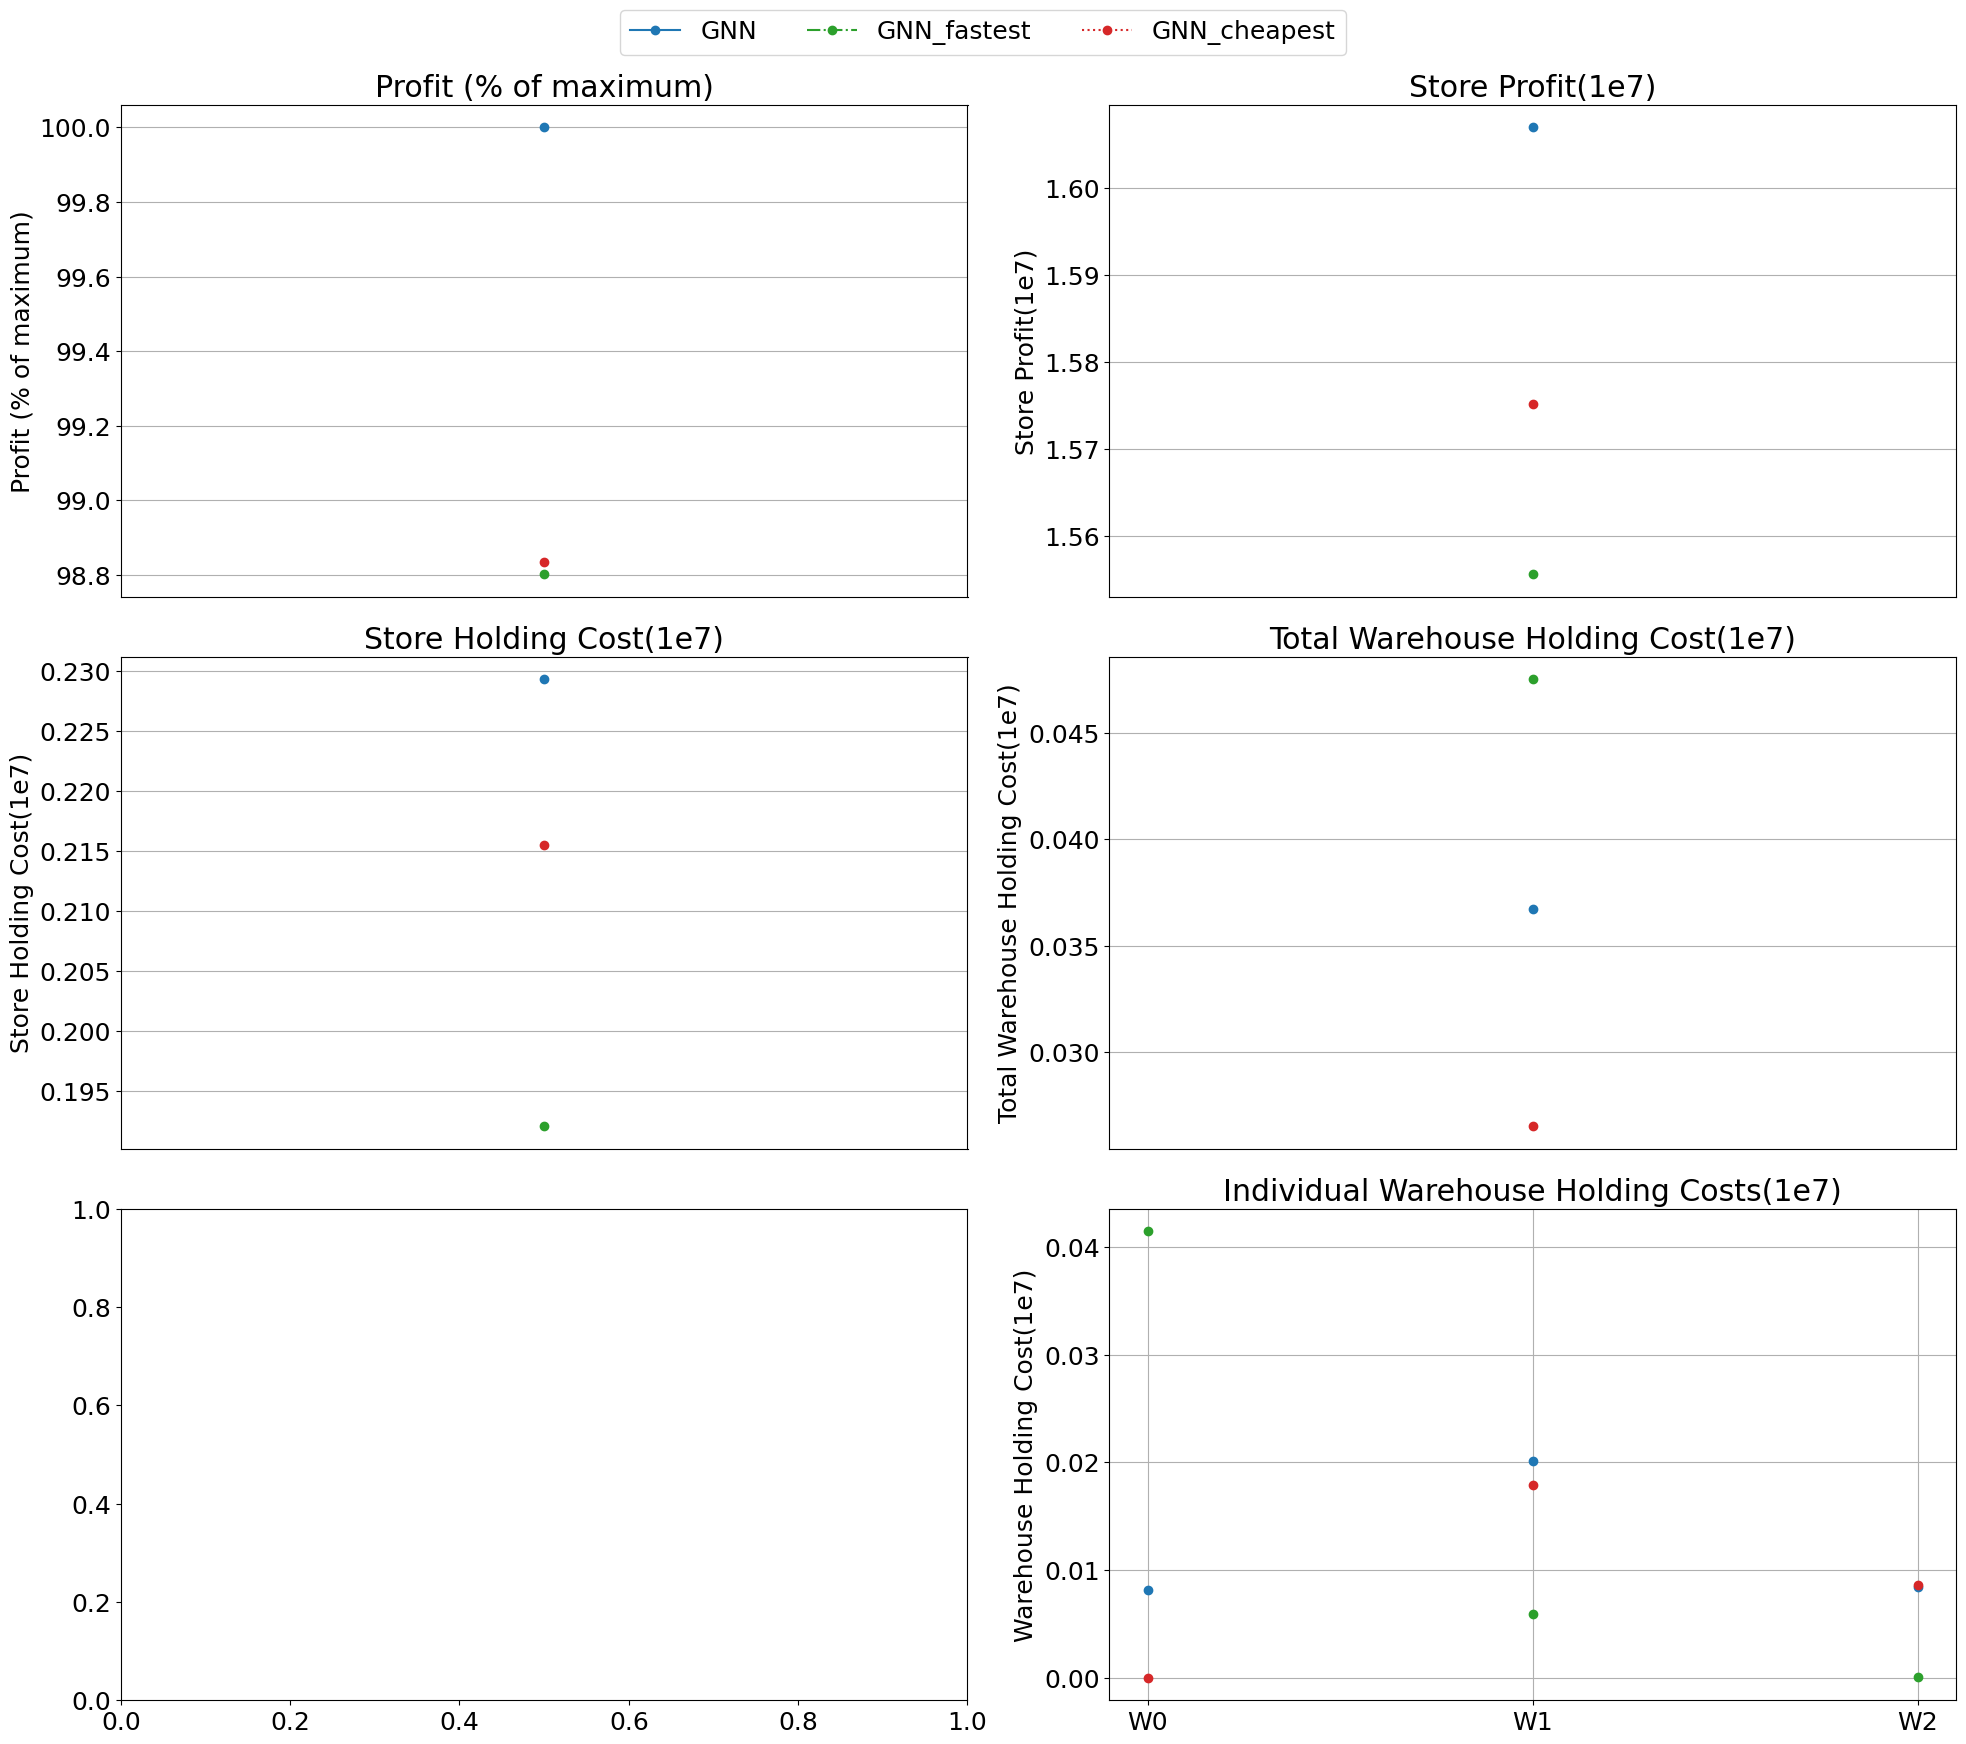

,# of stores,hyperparam_name,samples,Architecture Class,Learning Rate,Train Loss,Dev Loss,# of runs,path,n_warehouses,avg_s_underage,avg_s_holding,avg_w_holding,w_0_holding,w_1_holding,w_2_holding,avg_profit,profit
0,1,GNN_real,1,GNN,0.0010,-333.402857,-290.857991,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,3,1.607004e+07,2.292967e+06,367362.334248,81480.685662,201255.962359,84625.686228,6.851802e+07,100.000000
1,1,GNN_real_fastest,1,GNN_fastest,0.0001,-323.251361,-285.302325,7,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,3,1.555538e+07,1.921066e+06,475076.437481,414779.249443,59324.737544,972.450494,6.769649e+07,98.801000
2,1,GNN_real_cheapest,1,GNN_cheapest,0.0010,-327.619688,-289.167343,7,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,3,1.575177e+07,2.154766e+06,265230.945643,10.965909,178851.863428,86368.116306,6.771978e+07,98.834994


In [219]:
df_analysis = df[df['Architecture Class'] != 'Just-in-time']
df_analysis = df_analysis[df_analysis['Architecture Class'] != 'Data Driven']
collect_data_and_plot(df_analysis, 20, 3, 339, "test_on_dev", "n_warehouse_20_3_real_lost_demand", 5)